# Shapes Recognizer with MobileNet_v2 using transfer learning

### Description
This Jupyter notebook demonstrates the creation of a shape recognizer using transfer learning with MobileNet_v2. Transfer learning allows us to leverage the pre-trained MobileNet_v2 model, originally designed for image classification tasks, to recognize and classify various shapes in images (Squares , Circles , Stars , Triangles ) . By fine-tuning this powerful neural network on our shape dataset, we aim to achieve accurate shape recognition with minimal training effort. This notebook will guide you through the entire process, from data preparation to model training and evaluation, enabling you to build an efficient shape recognition system for your own applications.

The dataset was downloaded from Kaggle <a href="https://www.kaggle.com/datasets/smeschke/four-shapes">Link to the DataSet</a>.

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory

<ul>
<li>The images are of shape (224x224) as mentioned in the dataset's documentation
</li>
<li>The data format (shapes/class1/...    shapes/class2/...     shapes/...) has allowed the use of the <b>image_dataset_from_directory</b> function  
</li>
</ul>

In [2]:
IMG_SIZE = (224,224)
directory = "shapes/"
(train_dataset , validation_dataset ) = image_dataset_from_directory(directory,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='both',
                                             seed=64)

Found 14970 files belonging to 4 classes.
Using 11976 files for training.
Using 2994 files for validation.


#### <ul><li>A sample of the shapes in the dataset</li></ul>

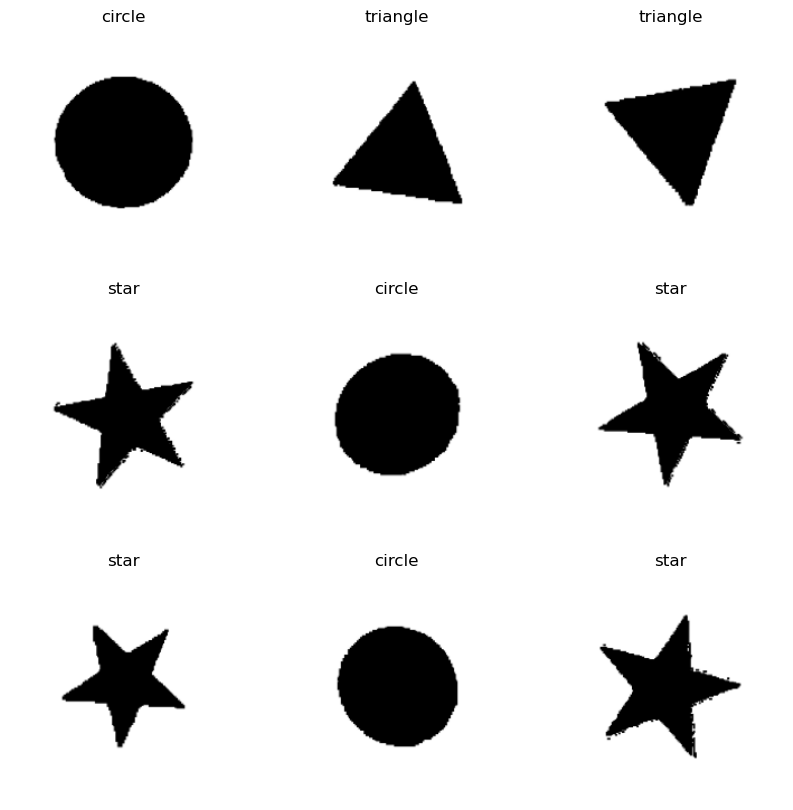

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

##### <ul> <li>  In most classification tasks, we often have a set of classes (shapes in this case) that we want our model to recognize. One-hot encoding is a technique used to represent these classes in a format that is suitable for neural network training.</li></ul>

In [4]:
def one_hot_labels(image, label):
    return image, tf.one_hot(label, depth=4)

train_dataset = train_dataset.map(one_hot_labels)
validation_dataset = validation_dataset.map(one_hot_labels)

#### The `preprocess_input` function from TensorFlow's MobileNetV2 module is responsible for preprocessing input images before they are fed into the model for prediction or training. It ensures that the input data is properly formatted and scaled to match the requirements of the MobileNetV2 model, optimizing its performance.

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### <ul><li>Optimizing Data Loading with tf.data.experimental.AUTOTUNE and prefetch</li></ul>
#### By utilizing tf.data.experimental.AUTOTUNE and prefetching, we optimize our data pipeline. During training, while the model is processing one batch of data, TensorFlow will asynchronously load the next batch in the background. This results in a more efficient use of available computational resources .

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

#### <ul><li>Defining the shape of an image, the ' + (3,) ' represents the image's three color channels (RGB).</li><li>Defining a base model for the sake of experimenting with the raw MobileNetV2 (without tuning). </li></ul>

In [6]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

### <ul><li>Displaying the architecture of the MobileNetV2</li></ul>

In [7]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

### MobileNetV2 can be broken down into these key blocks : 
#### <ul><li><b>Convolutional Layers:</b> MobileNetV2 starts with a series of convolutional layers that process the input image. These layers gradually reduce the spatial dimensions of the data while increasing the number of channels.</li><li><b>Bottleneck Blocks: </b>In each bottleneck block, you have three key components: a depthwise convolution, a 1x1 pointwise convolution (to mix information across channels), and a shortcut connection. This combination helps reduce computational complexity while preserving useful features.</li><li><b>Pooling Layer: </b>At the end of the network, there is typically a global average pooling layer. This layer computes the average value of each feature map, which reduces the spatial dimensions to a single value for each channel. This global average pooling step makes the network more robust to input size variations.</ul>The combination of bottlenecks and global average pooling makes MobileNetV2 computationally efficient and well-suited for tasks like image classification and object detection on mobile devices.

### Shapes_Model function
#### The <b>Shapes_Model`</b> function is responsible for creating a shape detection model. It employs the following steps:
#### <ul><li><b>Base Model Selection : </b>It starts by choosing the MobileNetV2 model as the base model. This base model is pretrained on a large dataset (ImageNet) and is well-suited for feature extraction.</li><li><b>Freezing Weights : </b>To preserve the knowledge learned during pretraining, the base model's weights are set to be non-trainable. This means that during the training of the shape detection model, only the additional layers will be updated while the base MobileNetV2 layers remain fixed.</li><li><b>Input Layer : </b>An input layer is defined to specify the shape of input images. This allows flexibility in handling images of different dimensions.</li><li><b>Image Preprocessing : </b>The input images are preprocessed using a custom `preprocess_input` function (function mentionned above) to prepare them for input to the base model.</li><li><b>Feature Extraction : </b>The preprocessed images are passed through the base model. The base model extracts features from the images, which are useful for recognizing shapes.</li><li><b>Global Average Pooling : </b>A Global Average Pooling 2D layer is applied to the output from the base model. This reduces the spatial dimensions and creates a fixed-size feature vector regardless of the input image size.</li><li><b>Dropout Layer : </b>To prevent overfitting, a dropout layer with a 20% dropout rate is added. This layer helps regularize the model during training.</li><li><b>Output Layer : </b>The final output layer is added with four units (four shape classes) and a softmax activation function. This layer produces probability distributions over the shape classes.</li><li><b>Model Compilation and Return : </b>The function compiles the model and returns it, ready for training and evaluation.</li></ul>

In [8]:

def Shapes_Model(image_shape=IMG_SHAPE):
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    
    base_model.trainable = False 
    
    inputs = tf.keras.Input(shape=image_shape)
    
    x = preprocess_input(inputs)
    
    x = base_model(x, training=False)
    
    x = tfl.GlobalAveragePooling2D()(x) 
    
    x = tfl.Dropout(0.2)(x)
    
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
    
    
    
    return tf.keras.Model(inputs, outputs)
    

#### After defining the `Shapes_Model` function, the next step is to compile the model for training. This involves specifying the optimizer ( Adam ), loss function (tf.keras.losses.CategoricalCrossentropy()), the learning rate ( 0.005) , and metrics used during the training process (accuracy).

In [11]:
model = Shapes_Model()
base_learning_rate = 0.005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [12]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=2)

Epoch 1/2


375/375 [==============================] - 234s 617ms/step - loss: 0.0106 - accuracy: 0.9957 - val_loss: 7.7643e-05 - val_accuracy: 1.0000
Epoch 2/2
375/375 [==============================] - 237s 633ms/step - loss: 8.9847e-05 - accuracy: 1.0000 - val_loss: 3.8263e-05 - val_accuracy: 1.0000


### Plotting <b>training</b> and <b>validation</b> metrics

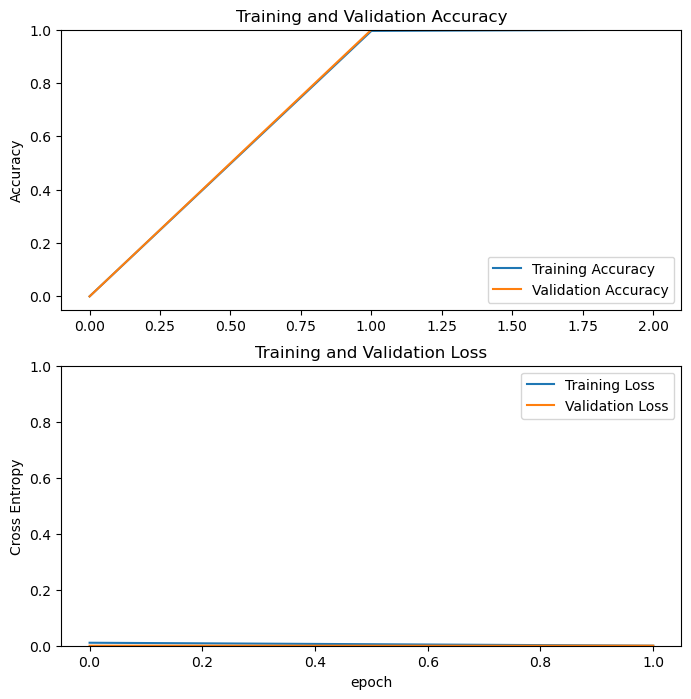

In [13]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### An achievement of 100% accuracy on the validation dataset is a strong indicator of the model's outstanding performance on this dataset.

#### I drew some shapes in Paint that closely resemble the ones in the dataset, and the model had no trouble recognizing them

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 52ms/step
The prediction : star


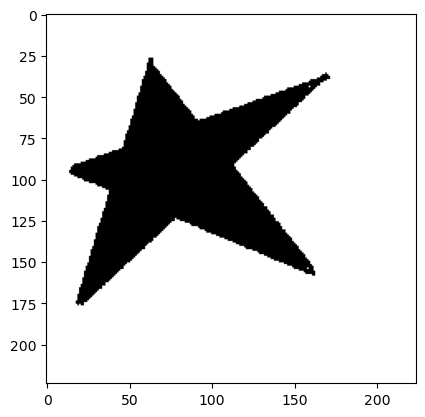

In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the image
image = load_img('paint_drawings_further_testing/paint_star.png', target_size=(224, 224))
image = img_to_array(image)
plt.imshow(image)
image = image.reshape((1, 224, 224,3)) 
predictions = model.predict(image)
predicted_class = tf.argmax(predictions, axis=1)[0].numpy()
predicted_label = class_names[predicted_class]
print("The prediction : {}".format(predicted_label))

#### Finally, saving the model's weights for reusability and future development.

In [17]:
model.save_weights('Weights/weights')